In [1]:
library(tidyverse)
library(ggplot2)
library(MatchIt)
library(dplyr)
library(tidyr)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [2]:
# Loading Data
data <- read_csv("../datahwk2.1/final-data.csv")
data2018 <- read_csv("../datahwk2.1/data-2018.csv")

Rows: 449046 Columns: 69
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (17): contractid, state, county, org_type, plan_type, partd, snp, eghp, ...
dbl (52): planid, fips, year.x, n_nonmiss, avg_enrollment, sd_enrollment, mi...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 85866 Columns: 69
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (17): contractid, state, county, org_type, plan_type, partd, snp, eghp, ...
dbl (51): planid, fips, year.x, n_nonmiss, avg_enrollment, sd_enrollment, mi...
lgl  (1): mean_risk

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [3]:
# clean data
data <- data %>%
  select(-starts_with("year")) %>%
  mutate(year = data$year.x)


# Question 1: Filter data and provide box and whisker plot

In [4]:
# Table of plan types
plan_type <- data %>%
  group_by(plan_type) %>%
  summarise(n_plans = n_distinct(planid)) %>%
  arrange(desc(n_plans))
plan_type

plan_type,n_plans
<chr>,<int>
Local PPO,255
HMO/HMOPOS,229
PFFS,89
1876 Cost,44
Regional PPO,35
Medicare-Medicaid Plan HMO/HMOPOS,7
National PACE,5
MSA,4


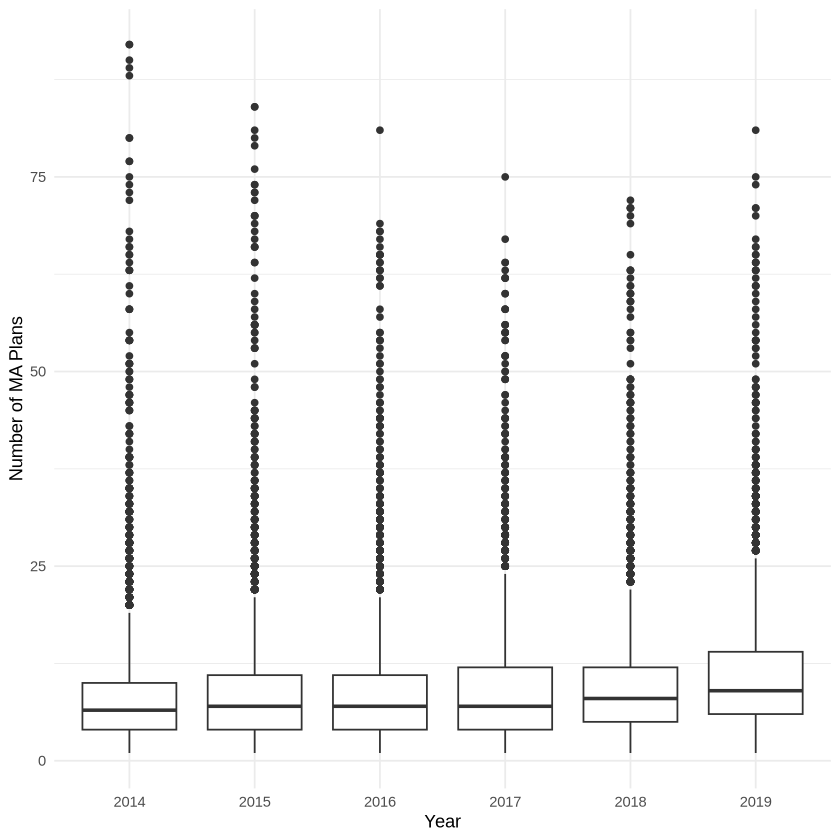

In [5]:
# 1. Filter plans: remove SNPs, 800-series, and prescription drug only
filtered_data <- data %>%
  filter(
    snp != "Yes",        
    !grepl("^8", planid),
    plan_type != "PDP"
  )

# Box and whisker plot of plan counts by count over time
county_plan_counts <- filtered_data %>%
  distinct(contractid, fips, year) %>%
  count(fips, year, name = "n_plans")

ggplot(county_plan_counts, aes(x = factor(year), y = n_plans)) +
  geom_boxplot() +
  labs(
    x = "Year",
    y = "Number of MA Plans") +
  theme_minimal()

# Question 2: Frequency histograms for 2018 and 2014

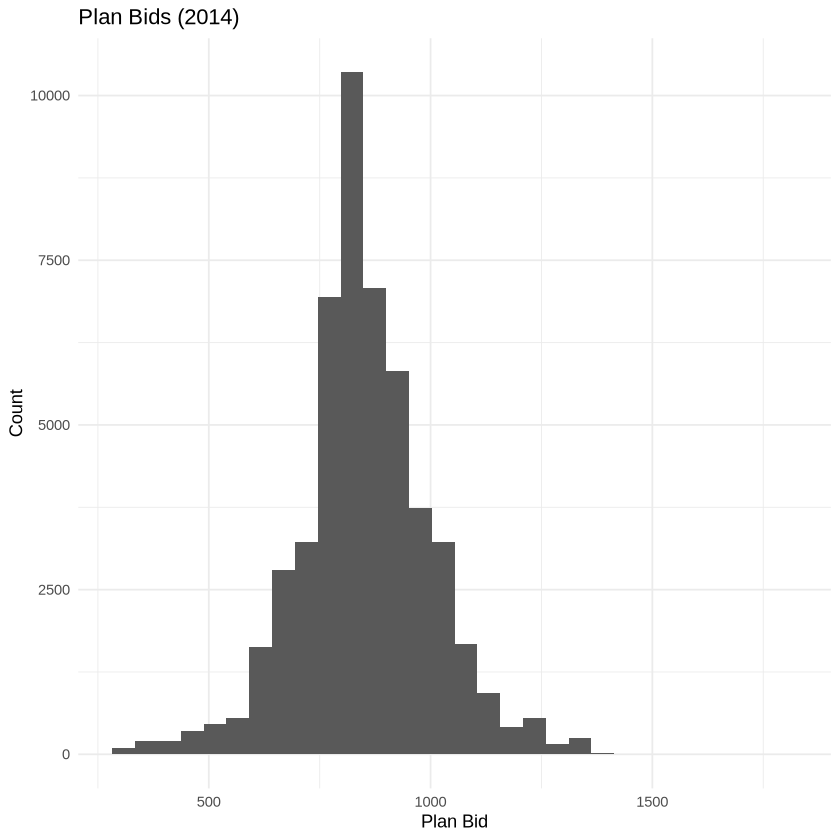

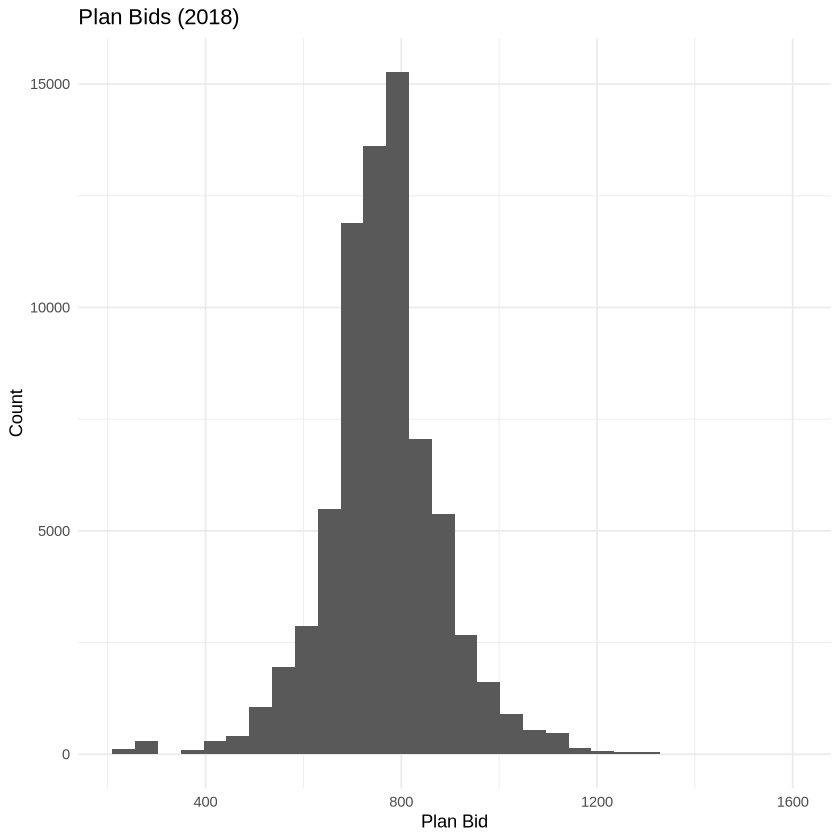

In [6]:
# Frequency histograms for 2014 vs 2018
# remove rows with NA
bids <- filtered_data %>%
    filter(!is.na(bid))

# Histogram for 2014
ggplot(filter(bids, year == 2014), aes(x = bid)) +
  geom_histogram(bins = 30) +
  labs(
    title = "Plan Bids (2014)",
    x = "Plan Bid",
    y = "Count") +
  theme_minimal()

# Histogram for 2018
ggplot(filter(bids, year == 2018), aes(x = bid)) +
  geom_histogram(bins = 30) +
  labs(
    title = "Plan Bids (2018)",
    x = "Plan Bid",
    y = "Count") +
  theme_minimal()


# Question 3: Plot average HHI over time from 2014 to 2019

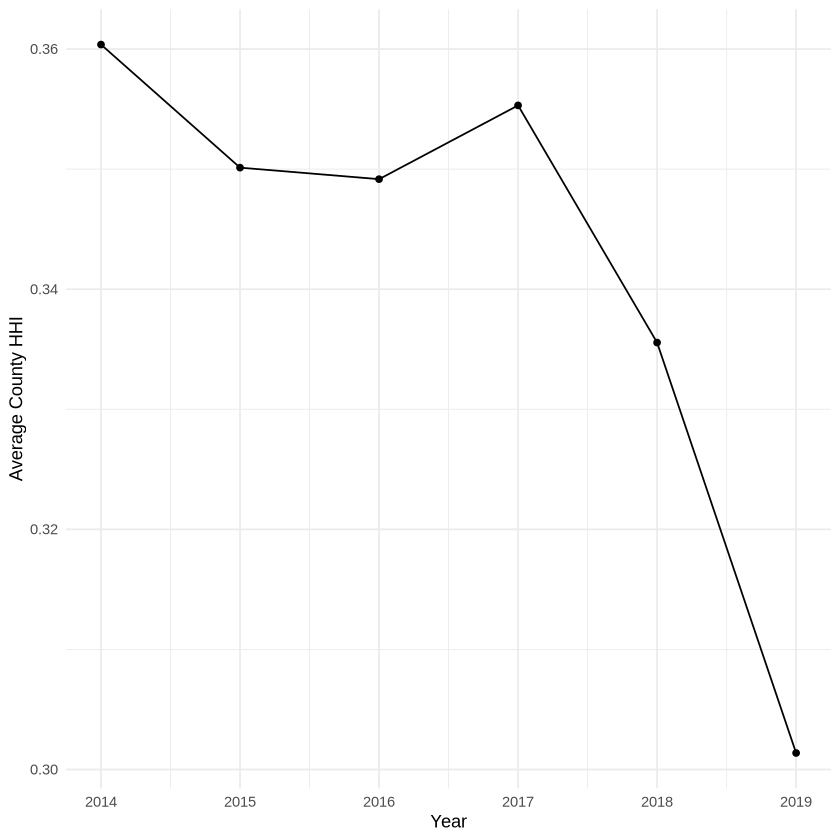

In [7]:
# Plot average HHI over time
# Compute HHI
county_hhi <- filtered_data %>%
  group_by(year, fips) %>%
  mutate(
    share = avg_enrollment / sum(avg_enrollment, na.rm = TRUE)
  ) %>%
  summarize(
    hhi = sum(share^2, na.rm = TRUE),
    .groups = "drop"
  )

# Average HHI by year
avg_hhi_year <- county_hhi %>%
  group_by(year) %>%
  summarize(
    avg_hhi = mean(hhi, na.rm = TRUE)
  )

# Plot HHI average
ggplot(avg_hhi_year, aes(x = year, y = avg_hhi)) +
  geom_line() +
  geom_point() +
  labs(
    x = "Year",
    y = "Average County HHI") +
  theme_minimal()

# Question 4: Plot average share of Medicare Advantage from 2014 to 2019

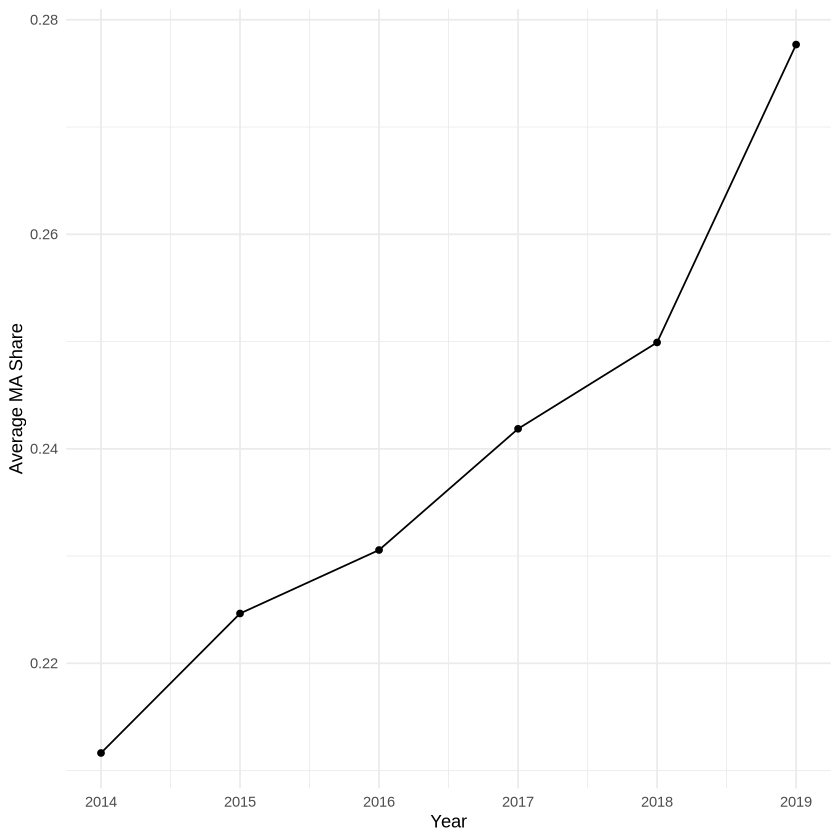

In [8]:
# Plot average share of Medicare Advantage
county_penetration <- filtered_data %>%
  group_by(year, fips) %>%
  summarize(
    ma_share = mean(avg_enrolled / avg_eligibles, na.rm = TRUE),
    .groups = "drop"
  )

# average by year
avg_penetration <- county_penetration %>%
  group_by(year) %>%
  summarize(
    avg_ma_share = mean(ma_share, na.rm = TRUE)
  )

# Plot of medicare advantage over time
ggplot(avg_penetration, aes(x = year, y = avg_ma_share)) +
  geom_line() +
  geom_point() +
  labs(
    x = "Year",
    y = "Average MA Share") +
  theme_minimal()


# Question 5: Average Bid among competitive versus uncompetitve markets

In [10]:
# load and clean data 2018
d18 <- data2018 %>%
  filter(
    snp != "Yes",        
    !grepl("^8", planid),
    plan_type != "PDP"
  )

In [12]:
county_totals <- d18 %>%
  group_by(fips) %>%
  summarise(
    total_ma_enrollment = sum(avg_enrollment),
    .groups = "drop"
  )
d18 <- d18 %>%
  left_join(county_totals, by = "fips") %>%
  mutate(
    market_share = avg_enrollment / total_ma_enrollment
  )
d18 %>%
  group_by(fips) %>%
  summarise(sum_shares = sum(market_share))

fips,sum_shares
<dbl>,<dbl>
1001,NA
1003,NA
1005,NA
1007,NA
1009,NA
1011,NA
1013,NA
1015,NA
1017,NA


In [13]:

hhi_33 <- quantile(d18$hhi, probs = 0.33, na.rm = TRUE)
hhi_66 <- quantile(d18$hhi, probs = 0.66, na.rm = TRUE)

library(dplyr)

d18 <- d18 %>%
  mutate(
    market_competition = case_when(
      hhi <= hhi_33 ~ "Competitive",
      hhi >= hhi_66 ~ "Uncompetitive",
      TRUE ~ "Mid-range"   # optional, for HHIs between 33rd and 66th percentile
    )
  )

Warning message:
“Unknown or uninitialised column: `hhi`.”
Warning message:
“Unknown or uninitialised column: `hhi`.”


ERROR: [1m[33mError[39m in `mutate()`:[22m
[1m[22m[36mℹ[39m In argument: `market_competition = case_when(...)`.
[1mCaused by error in `case_when()`:[22m
[1m[22m[33m![39m Failed to evaluate the left-hand side of formula 1.
[1mCaused by error:[22m
[33m![39m object 'hhi' not found


In [ ]:
avg_bid <- d18 %>%
  group_by(market_competition) %>%
  summarise(
    avg_bid = mean(bid, na.rm = TRUE),
    n_obs = n()  # optional, to see number of observations
  ) %>%
  arrange(market_competition)

avg_bid


# Question 6: Split Markets into quanrtiles based on Medicare FFS costs

In [ ]:
long_quartiles <- d18 %>%
  select(avg_ffscost, ffs_q1, ffs_q2, ffs_q3, ffs_q4) %>%
  pivot_longer(
    cols = starts_with("ffs_q"),
    names_to = "Quartile",
    values_to = "in_quartile"
  ) %>%
  filter(in_quartile == 1)

avg_cost_table <- long_quartiles %>%
  group_by(Quartile) %>%
  summarise(
    avg_cost = mean(avg_ffscost, na.rm = TRUE),
    n_obs = n()
  ) %>%
  arrange(Quartile)

avg_cost_table


# Question 7: ATE with estimators

In [ ]:
# nearest neighbor matching with inverse variance distance besed on quartiles of FFS cost
m_ps <- matchit(
  competitive ~ factor(ffs_quartile),
  data = d18,
  method = "nearest",
  ratio = 1
)

ps_dat <- match.data(m_ps)

ate_ps <- with(
  ps_dat,
  mean(bid[competitive == 1]) - mean(bid[competitive == 0])
)


In [ ]:
# nearest neighbor matching with Mahalanobis distance based on quartiles of FFS costs
m_mah <- matchit(
  competitive ~ factor(ffs_quartile),
  data = d18,
  method = "nearest",
  distance = "mahalanobis",
  ratio = 1
)

mah_dat <- match.data(m_mah)

ate_mah <- with(
  mah_dat,
  mean(bid[competitive == 1]) - mean(bid[competitive == 0])
)


In [ ]:
# Inverse propensity weighting, where the propensity scores are based on quartiles of FFS costs
ps_mod <- glm(
  competitive ~ factor(ffs_quartile),
  data = d18,
  family = binomial
)

d18 <- d18 %>%
  mutate(
    ps = predict(ps_mod, type = "response"),
    w = ifelse(competitive == 1, 1 / ps, 1 / (1 - ps))
  )

ate_ipw <- with(
  d18,
  weighted.mean(bid[competitive == 1], w[competitive == 1]) -
    weighted.mean(bid[competitive == 0], w[competitive == 0])
)


In [ ]:
# Simple linear regression, adjusting for quartiles of FFS costs using dummy variables and appropriate interactions
reg <- lm(
  bid ~ competitive * factor(ffs_quartile),
  data = d18
)

summary(reg)


In [ ]:
# comparison table
tibble(
  Method = c(
    "NN Matching (PS)",
    "NN Matching (Mahalanobis)",
    "IPW",
    "Linear Regression"
  ),
  ATE = c(
    ate_ps,
    ate_mah,
    ate_ipw,
    coef(reg)["competitive"]
  )
)


# Question 8

# Question 9: re-estimate treatment effects using the continuous FFS costs variable as well at total Medicare beneficiaries as covariates

In [ ]:
# use avg_ffscost and avg_eligibles
ps_cont <- glm(
  competitive ~ avg_ffscost + avg_eligibles,
  data = d18,
  family = binomial
)

d18 <- d18 %>%
  mutate(
    ps2 = predict(ps_cont, type = "response"),
    w2 = ifelse(competitive == 1, 1 / ps2, 1 / (1 - ps2))
  )

ate_ipw_cont <- with(
  d18,
  weighted.mean(bid[competitive == 1], w2[competitive == 1]) -
    weighted.mean(bid[competitive == 0], w2[competitive == 0])
)


In [ ]:
for q in quartiles:
    avg_bid = df.groupby('treated')[q].mean()
    results[q] = avg_bid

table =pd.DataFrame(results)
print(table)